In [1]:
from nustar_gen.radial_profile import find_source, make_radial_profile, optimize_radius_snr
from nustar_gen.wrappers import make_image

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np

In [3]:
from nustar_gen import info
obs = info.Observation(path='../data/', seqid='30001143002')
obs.exposure_report()
obs.science_files

for mod in ['A', 'B']:
    for file in obs.science_files[mod]:
        hdr = fits.getheader(file)
        print(f"{file}, exposure: {1e-3*hdr['EXPOSURE']:20.4} ks")
    print()

Exposure for FPMA, mode 01 is:      47.79 ks
Exposure for FPMA, mode 06 is:      26.89 ks

Exposure for FPMB, mode 01 is:      47.75 ks
Exposure for FPMB, mode 06 is:      26.85 ks

../data/30001143002/event_cl/nu30001143002A01_cl.evt, exposure:                47.79 ks
../data/30001143002/event_cl/nu30001143002A06_chu13_N_cl.evt, exposure:                1.948 ks
../data/30001143002/event_cl/nu30001143002A06_chu23_N_cl.evt, exposure:                8.921 ks
../data/30001143002/event_cl/nu30001143002A06_chu2_N_cl.evt, exposure:               0.1523 ks
../data/30001143002/event_cl/nu30001143002A06_chu3_N_cl.evt, exposure:                15.87 ks

../data/30001143002/event_cl/nu30001143002B01_cl.evt, exposure:                47.75 ks
../data/30001143002/event_cl/nu30001143002B06_chu13_N_cl.evt, exposure:                1.948 ks
../data/30001143002/event_cl/nu30001143002B06_chu23_N_cl.evt, exposure:                8.904 ks
../data/30001143002/event_cl/nu30001143002B06_chu2_N_cl.evt, exposu

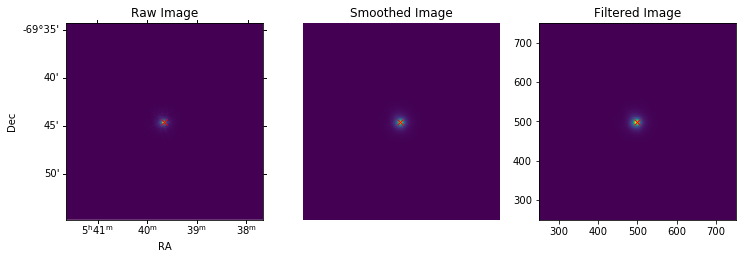

In [4]:
mod='B'
infile = obs.science_files[mod][0]
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
coordinates = find_source(full_range, show_image = True, filt_range=3)

In [5]:
# Get the WCS header and convert the pixel coordinates into an RA/Dec object
hdu = fits.open(full_range, uint=True)[0]
wcs = WCS(hdu.header)

# The "flip" is necessary to go to [X, Y] ordering from native [Y, X] ordering, which wcs seems to require
world = wcs.all_pix2world(np.flip(coordinates), 0)
ra = world[0][0]
dec = world[0][1]
target = SkyCoord(ra, dec, unit='deg', frame='fk5')
print(target)
obj_j2000 = SkyCoord(hdu.header['RA_OBJ'], hdu.header['DEC_OBJ'], unit = 'deg', frame ='fk5')

# How far are we from the J2000 coordinates? If <15 arcsec, all is okay
sep = target.separation(obj_j2000)
print(sep)


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (84.91478834, -69.74426419)>
0d00m05.218s


In [6]:
# Now the radial image parts.

# Make the radial image for the full energy range (or whatever is the best SNR)
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
rind, rad_profile, radial_err, psf_profile = make_radial_profile(full_range, show_image=False,
                                                                 coordinates = coordinates)

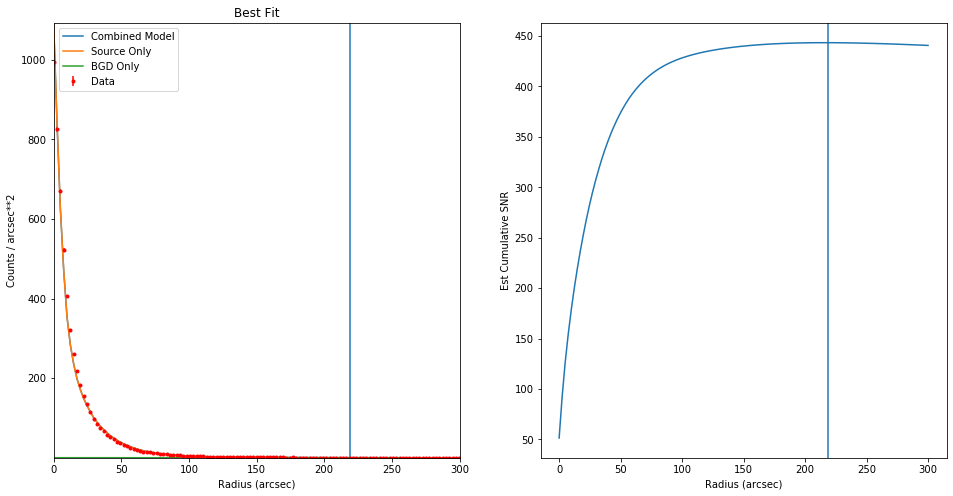

Radius of peak SNR for 3 to 20 keV: 218.77155504


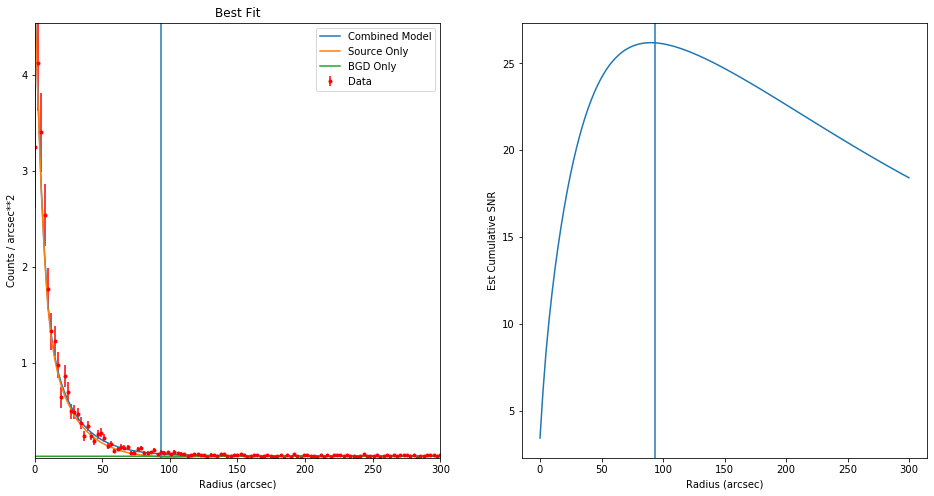

Radius of peak SNR for 20 to 30 keV: 93.40807968


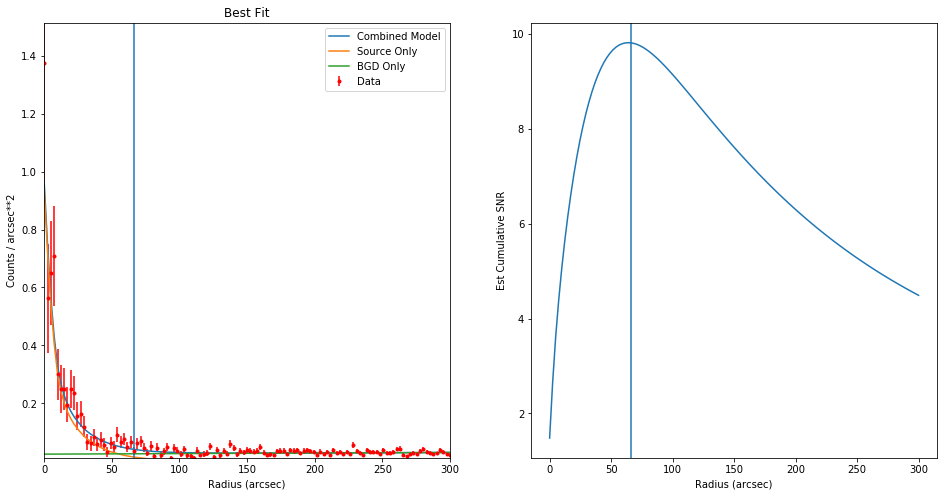

Radius of peak SNR for 30 to 40 keV: 66.36889872


/Users/bwgref/science/local/miniconda3/envs/nustar/lib/python3.7/site-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/bwgref/science/local/miniconda3/envs/nustar/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


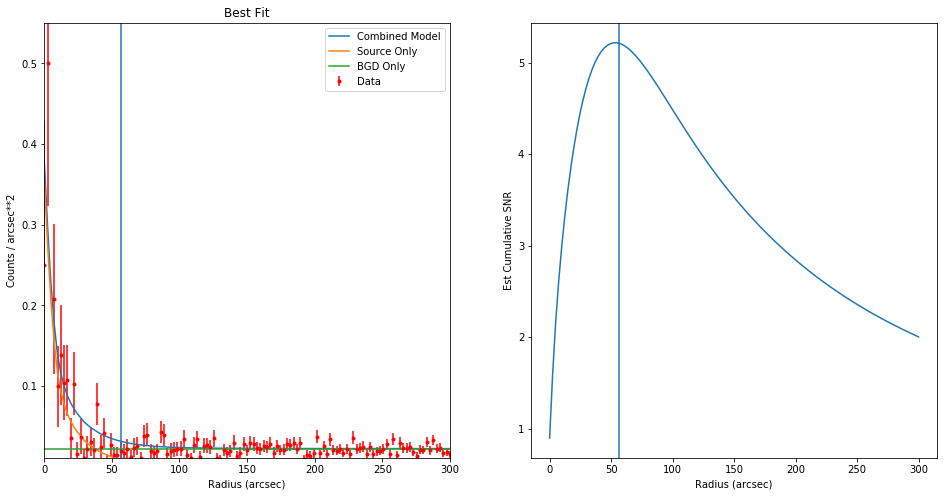

Radius of peak SNR for 40 to 50 keV: 56.53646928


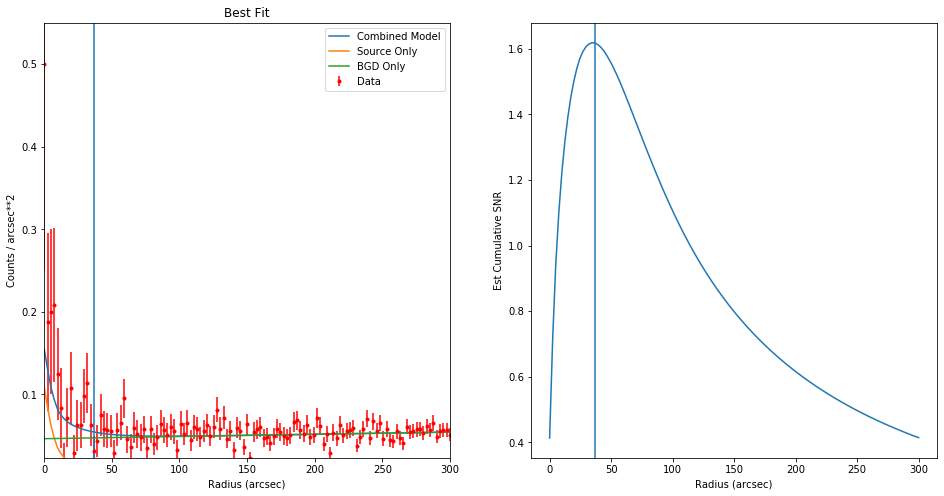

Radius of peak SNR for 50 to 80 keV: 36.8716104


In [7]:
# Pick energy ranges that you want to check.

# Note that this formalism breaks down when the source isn't detected, so use your best judgement here.

# Below should be used as a "best guess" when choosing a radius for spectral extraction.

# For the 3-20 keV case, the source dominates out the edge of the FoV (and the assumptoons about the PSF
# start to break down in the fit).

# This a soft source (LMC X-1), so for 20-30 keV we already see that we need to restrict the radius that we
# use so that we're not just adding noise to the spectrum.

pairs = [[3, 20], [20, 30], [30, 40], [40, 50], [50, 80]]
coordinates = find_source(full_range, show_image = False)
for pair in pairs:
    test_file = make_image(infile, elow = pair[0], ehigh = pair[1], clobber=True)
    rind, rad_profile, radial_err, psf_profile = make_radial_profile(test_file, show_image=False,
                                                                     coordinates = coordinates)
    rlimit = optimize_radius_snr(rind, rad_profile, radial_err, psf_profile, show=True)
    print('Radius of peak SNR for {} to {} keV: {}'.format(
            pair[0], pair[1], rlimit))

In [8]:
import regions
import astropy.units as u

In [9]:
source_reg = [regions.CircleSkyRegion(center=target, radius=60*u.arcsec)]
outfile = obs._evdir+f'/src{mod}01.reg'
regions.write_ds9(source_reg, outfile, radunit='arcsec')